# Apply a trained SSD to images

My first foray into object detection, nothing fancy.

Train the model using `train.sh` and export it using `export.sh`. Use this Notebook to apply the exported model to test images. During training use `eval.sh` to evaluate the model trained so far and `tensorboard.sh` to start TensorBoard.

After only 89 steps the model, using the [SSD+Inception v2 architecture trained on the COCO](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) is able to make predictions, though not overly accurate of course.

Data set: http://dlib.net/files/data/dlib_front_and_rear_vehicles_v1.tar

Code heavily based on:

- [TensorFlow Object Detection API demo](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)
- [Deep Learning for Computer Vision](https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/) by Adrian Rosebrock

# Examples

The predictions shown below were created using a model trained for 200,000 steps.

Test image 1:

![Original image](data/inference/image1.jpg)

![Original image](data/inference/image1_pred.jpg)

Test image 2:

![Original image](data/inference/image2.jpg)

![Original image](data/inference/image2_pred.jpg)

Test image 3:

![Original image](data/inference/image3.jpg)

![Original image](data/inference/image3_pred.jpg)

# Prediction code

In [1]:
from object_detection.utils import label_map_util
from utils import visualization_utils as vis_util
import tensorflow as tf
import numpy as np
import cv2, os
from matplotlib import pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/DL-TFOD-API/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Path to the folder containing test images

In [2]:
IMAGE_FOLDER_PATH = "./data/inference"

# Constants

In [3]:
MODEL_PATH = "./models/model/export/frozen_inference_graph.pb"
LABEL_PATH = "./data/classes.pbtxt"
NUM_CLASSES = 2
MIN_CONFIDENCE = 0.5
COLORS = np.random.uniform(0, 255, size=(NUM_CLASSES, 3))

# Load the trained model

In [4]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    # Init graph definition and load the frozen inference graph
    graphDef = tf.GraphDef()
    with tf.gfile.GFile(MODEL_PATH, "rb") as f:
        serializedGraph = f.read()
        graphDef.ParseFromString(serializedGraph)
        tf.import_graph_def(graphDef, name="")

# Load the label map

In [5]:
label_map = label_map_util.load_labelmap(LABEL_PATH)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES,
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Perform inference

In [6]:
def run_inference_for_single_image(image, graph):
    """Apply the model to a single image, taken from:
    https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
    """
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores',
                        'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
            
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            
            if 'detection_masks' in tensor_dict:
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)

                # Translate box coordinates from [0, 1] to image coordinates
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)

                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference, expand dimensions because the model expects shape: [1, None, None, 3]
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # All outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]

    return output_dict

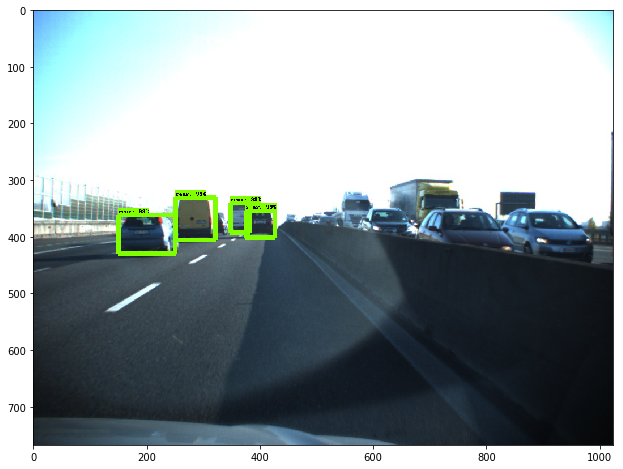

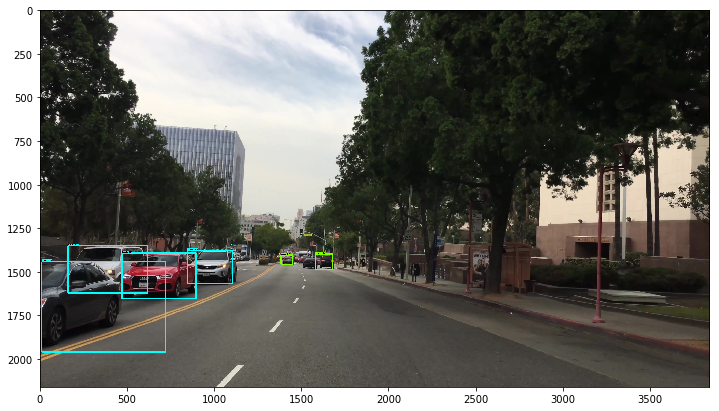

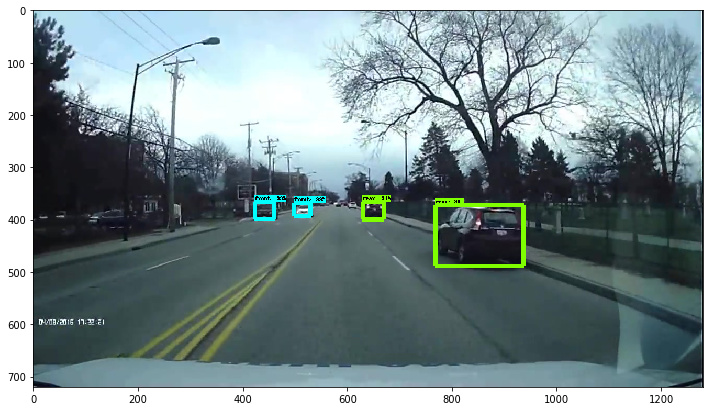

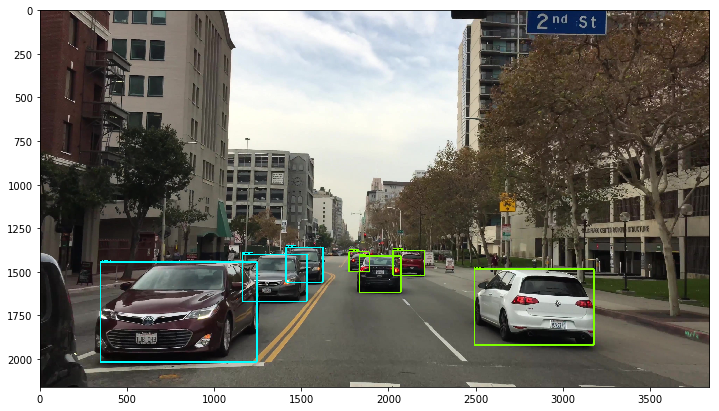

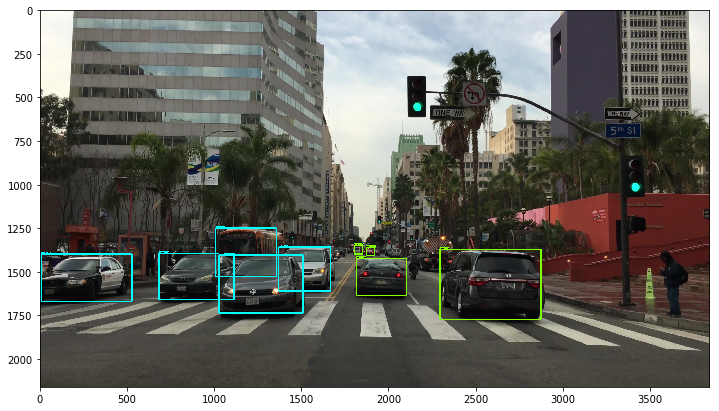

In [7]:
TEST_IMAGE_PATHS = [os.path.join(IMAGE_FOLDER_PATH, 'image{}.jpg'.format(i)) for i in range(1, 6) ]

for image_path in TEST_IMAGE_PATHS:
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

    # Run detection
    output_dict = run_inference_for_single_image(image, detection_graph)

    # Visualise the results
    vis_util.visualize_boxes_and_labels_on_image_array(
        image,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)

    # Show bounding boxes
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    
    # Save to disk
    filename, file_extension = os.path.splitext(image_path)
    plt.imsave(filename + "_pred" + file_extension, image)

# End of notebook